# 🔮 VLM Fine-tuning with LoRA

## Visual Instruction Tuning for Physical AI

This tutorial demonstrates how to fine-tune Vision Language Models using
parameter-efficient methods (LoRA). VLMs are the perception backbone of
Physical AI systems—enabling robots to understand scenes, identify objects,
and respond to natural language queries about their environment.

### Learning Objectives
1. Load and configure a VLM for fine-tuning
2. Prepare visual instruction tuning data
3. Apply LoRA for efficient training
4. Evaluate VLM performance

### Use Cases in Physical AI
- Scene understanding ("What objects are on the table?")
- Object identification ("Where is the red cube?")
- Safety assessment ("Is the path clear?")
- Human detection ("Is anyone in the workspace?")

### Prerequisites
- GPU with 16GB+ memory (T4, A100)
- Hugging Face account for model access

---

## ⚠️ Common Fine-tuning Pitfalls (Read Before Training!)

Fine-tuning pretrained models is powerful but can easily go wrong. Here are the most
common failure modes and how to avoid them:

### 1. Catastrophic Forgetting
**What happens**: Model "forgets" its pretrained capabilities and produces garbage.
**Cause**: Learning rate too high, or training on data too different from pretraining.
**Fix**: Use lower learning rates (1e-5 to 5e-6), fewer trainable parameters (low LoRA rank).

### 2. Token Copying / Prompt Echoing  
**What happens**: Model just repeats the input question instead of answering.
**Cause**: Insufficient training signal, or format mismatch with pretrained expectations.
**Fix**: Use 1000+ quality samples, match the exact prompt format the model expects.

### 3. Format Mismatch
**What happens**: Model's outputs are malformed or nonsensical.
**Cause**: Training data format doesn't match the pretrained model's expected format.
**Fix**: Study the model's documentation and use its exact task prompts (e.g., Florence-2
uses `<CAPTION>`, `<VQA>`, `<OD>` task tokens).

### 4. Overfitting on Small Data
**What happens**: Perfect training loss but terrible real-world performance.
**Cause**: Too many epochs on too few samples.
**Fix**: Use more data, early stopping, or stronger regularization (dropout, weight decay).

### Rule of Thumb for Fine-tuning
```
┌─────────────────────────────────────────────────────────────────┐
│  Dataset Size    │  Recommended Approach                       │
├─────────────────────────────────────────────────────────────────┤
│  < 100 samples   │  Few-shot prompting, no fine-tuning         │
│  100-1000        │  LoRA with r=4-8, lr=1e-5, 1-3 epochs       │
│  1000-10000      │  LoRA with r=8-16, lr=2e-5, 3-5 epochs      │
│  10000+          │  Full fine-tune or LoRA r=16-64             │
└─────────────────────────────────────────────────────────────────┘
```

---

## 1. Environment Setup

In [1]:
!pip install -q torch torchvision
!pip install -q transformers>=4.40.0
!pip install -q accelerate>=0.27.0
!pip install -q bitsandbytes>=0.42.0
!pip install -q peft>=0.10.0
!pip install -q datasets>=2.18.0
!pip install -q trl>=0.8.0
!pip install -q pillow
!pip install -q wandb
!pip install -q evaluate

print("✅ Packages installed successfully!")

# %%
import os
import torch
import numpy as np
from PIL import Image
from typing import Dict, List, Optional
from dataclasses import dataclass
import json

from transformers import (
    AutoProcessor,
    AutoModelForCausalLM,  # Florence-2 uses CausalLM, not Vision2Seq
    TrainingArguments,
    Trainer,
)

# BitsAndBytesConfig may not be available without bitsandbytes
try:
    from transformers import BitsAndBytesConfig
except ImportError:
    BitsAndBytesConfig = None
    print("⚠️ BitsAndBytesConfig not available - quantization disabled")
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset, Dataset
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


✅ Packages installed successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


## 2. Tutorial Configuration

Choose your tutorial speed based on available time and compute.

In [20]:
# ============================================================
# TUTORIAL MODE CONFIGURATION
# ============================================================
# Change this to control dataset size and training time

TUTORIAL_MODE = "fast"  # Options: "fast", "standard", "full"

MODE_CONFIGS = {
    "fast": {
        "num_samples": 50,      # Very small for quick demo
        "num_epochs": 10,
        "eval_samples": 5,
        "description": "Quick demo (~3 min on T4)",
    },
    "standard": {
        "num_samples": 200,     # Moderate size, fits in Colab RAM
        "num_epochs": 20,
        "eval_samples": 20,
        "description": "Meaningful training (~15 min on T4)",
    },
    "full": {
        "num_samples": 500,     # Reduced to fit Colab high-RAM
        "num_epochs": 40,
        "eval_samples": 50,
        "description": "Full training (~45 min on T4)",
    },
}

config = MODE_CONFIGS[TUTORIAL_MODE]

print(f"""
╔═══════════════════════════════════════════════════════════════╗
║  TUTORIAL CONFIGURATION                                        ║
╠═══════════════════════════════════════════════════════════════╣
║  Mode:           {TUTORIAL_MODE:>10}                                    ║
║  Training samples: {config['num_samples']:>7}                                    ║
║  Epochs:         {config['num_epochs']:>10}                                    ║
║  Eval samples:   {config['eval_samples']:>10}                                    ║
║  Est. Time:      {config['description']:>25}         ║
║                                                                ║
║  💡 Change TUTORIAL_MODE above for different speeds            ║
╚═══════════════════════════════════════════════════════════════╝
""")


╔═══════════════════════════════════════════════════════════════╗
║  TUTORIAL CONFIGURATION                                        ║
╠═══════════════════════════════════════════════════════════════╣
║  Mode:                 fast                                    ║
║  Training samples:      50                                    ║
║  Epochs:                 10                                    ║
║  Eval samples:            5                                    ║
║  Est. Time:      Quick demo (~3 min on T4)         ║
║                                                                ║
║  💡 Change TUTORIAL_MODE above for different speeds            ║
╚═══════════════════════════════════════════════════════════════╝



## 3. Hugging Face Authentication

In [3]:
from huggingface_hub import login

# Uncomment to login (required for some models)
login()

print("💡 Run login() if you need access to gated models")

💡 Run login() if you need access to gated models


## 4. Load Dataset

We'll use the LLaVA-Instruct dataset, which contains visual instruction-following
examples. This teaches VLMs to respond to questions about images.

In [21]:
print("📥 Loading dataset...")

# We'll try multiple dataset options in order of preference
# Note: Many older HF datasets use deprecated loading scripts
# We prioritize datasets using modern Parquet format
dataset_name = None
full_dataset = None

# List of datasets to try (in order of preference)
DATASET_OPTIONS = [
    # (repo_id, config_name, split, description)
    # Beans: Small, reliable dataset of leaf diseases (healthy, angular_leaf_spot, bean_rust)
    ("beans", None, "train", "Beans Leaf Disease (Reliable & Open)"),

    # Fashion MNIST: Extremely reliable backup
    ("fashion_mnist", None, "train", "Fashion MNIST (Backup)"),
]

for repo_id, config_name, split, description in DATASET_OPTIONS:
    try:
        print(f"Trying {description}...")
        if config_name:
            full_dataset = load_dataset(repo_id, config_name, split=split)
        else:
            full_dataset = load_dataset(repo_id, split=split)

        # Check if dataset has enough samples
        if len(full_dataset) < 50:
            print(f"   Skipping: too few samples ({len(full_dataset)})")
            continue

        dataset_name = repo_id.split("/")[-1]
        print(f"✅ Loaded {dataset_name}")
        break
    except Exception as e:
        print(f"   Unavailable: {str(e)[:60]}...")
        continue

if full_dataset is None:
    print("\n⚠️ Could not load any external dataset.")
    print("   Using synthetic demonstration dataset instead.")
else:
    print(f"   Total samples available: {len(full_dataset)}")


📥 Loading dataset...
Trying Beans Leaf Disease (Reliable & Open)...
✅ Loaded beans
   Total samples available: 1034


In [22]:
# Subset the data based on tutorial mode
if full_dataset is not None:
    num_samples = min(config["num_samples"], len(full_dataset))
    dataset = full_dataset.shuffle(seed=42).select(range(num_samples))

    # Create train/eval split
    split = dataset.train_test_split(test_size=0.1, seed=42)
    train_dataset = split["train"]
    eval_dataset = split["test"].select(range(min(config["eval_samples"], len(split["test"]))))

    print(f"✅ Using {len(train_dataset)} training samples from {dataset_name}")
    print(f"✅ Using {len(eval_dataset)} evaluation samples")
    USE_REAL_DATASET = True
else:
    print("⚠️ No external dataset loaded - will use synthetic demo data")
    train_dataset = None
    eval_dataset = None
    USE_REAL_DATASET = False

✅ Using 45 training samples from beans
✅ Using 5 evaluation samples


In [23]:
# Inspect dataset structure
if USE_REAL_DATASET and train_dataset is not None:
    print("\n📋 Dataset structure:")
    print(f"   Columns: {train_dataset.column_names}")
    print(f"\n   Sample content:")
    sample = train_dataset[0]
    for key, value in sample.items():
        if isinstance(value, str):
            display_val = value[:80] + "..." if len(value) > 80 else value
            print(f"     {key}: \"{display_val}\"")
        elif isinstance(value, Image.Image):
            print(f"     {key}: PIL Image {value.size}")
        elif isinstance(value, (list, dict)):
            print(f"     {key}: {type(value).__name__} with {len(value)} items")
        else:
            print(f"     {key}: {type(value).__name__}")
else:
    print("\n📋 Will use synthetic demo dataset (created in Section 8)")


📋 Dataset structure:
   Columns: ['image_file_path', 'image', 'labels']

   Sample content:
     image_file_path: "/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de588..."
     image: PIL Image (500, 500)
     labels: int


## 5. Load Model

We'll use Florence-2 as our base VLM—it's open, efficient, and works well
for fine-tuning. For larger scale, you could use PaliGemma or LLaVA.

In [24]:
print("🔮 Loading Vision Language Model...")

# Model selection
MODEL_ID = "microsoft/Florence-2-base"  # Lightweight, open

# Note: For better quality, you could use:
# MODEL_ID = "google/paligemma-3b-pt-224"  # Requires login
# MODEL_ID = "llava-hf/llava-1.5-7b-hf"    # Larger, better

🔮 Loading Vision Language Model...


In [25]:
# Configure quantization
# Florence-2-base is small (0.23B params), so we can often run it in FP16/BF16 on T4 (16GB)
# This avoids quantization-related errors ("GET was unable to find an engine...")
USE_QUANTIZATION = False  # Set to True if OOM occurs

bnb_config = None
if USE_QUANTIZATION and torch.cuda.is_available() and BitsAndBytesConfig is not None:
    try:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
        )
        print("✅ 4-bit quantization enabled")
    except Exception as e:
        print(f"⚠️ Quantization not available: {e}")
        bnb_config = None
else:
    print("ℹ️ Quantization disabled (running in full precision for stability)")

# Load processor and model
print(f"Loading {MODEL_ID}...")

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)

# Note: Florence-2 uses AutoModelForCausalLM
# Using float32 for maximum compatibility (avoids dtype mismatch errors on T4)
# Florence-2-base is small enough (0.23B) to run in float32 on T4
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto" if torch.cuda.is_available() else None,
    trust_remote_code=True,
    torch_dtype=torch.float32,  # float32 for stability (model is small enough)
    attn_implementation="eager",
)

print(f"✅ Model loaded!")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

ℹ️ Quantization disabled (running in full precision for stability)
Loading microsoft/Florence-2-base...
✅ Model loaded!
   Total parameters: 231.4M


## 6. Configure LoRA

LoRA (Low-Rank Adaptation) allows us to fine-tune efficiently by only
training a small number of additional parameters.

In [26]:
# Find target modules for LoRA
# Different models have different layer names
def find_target_modules(model):
    """
    Find linear layers suitable for LoRA.

    For Florence-2, we target attention layers in the language model.
    """
    target_modules = set()

    # First, try to find modules dynamically
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            layer_name = name.split(".")[-1]
            # Common attention layer names
            if layer_name in ["q_proj", "k_proj", "v_proj", "o_proj", "qkv", "out_proj"]:
                target_modules.add(layer_name)

    # If nothing found, use known working defaults for Florence-2
    if not target_modules:
        # Florence-2 uses these attention layers in its language model
        target_modules = {"q_proj", "k_proj", "v_proj", "o_proj"}
        print("Using default target modules for Florence-2")

    return list(target_modules)

target_modules = find_target_modules(model)

# Fallback: if still empty, use regex pattern to match any proj layers
if not target_modules:
    print("⚠️ No specific modules found, using regex pattern")
    target_modules = r".*proj.*"  # Match any layer with 'proj' in name

print(f"Target modules for LoRA: {target_modules}")


Target modules for LoRA: ['qkv', 'q_proj', 'k_proj', 'v_proj', 'out_proj']


In [27]:
# Configure LoRA
# ============================================================
# IMPORTANT: LoRA Hyperparameter Guidelines
# ============================================================
# - Rank (r): Lower = fewer params, less risk of forgetting
#   Use r=4-8 for small datasets (<1000), r=16+ for large
# - Alpha: Controls effective learning rate scaling
#   Effective scale = alpha / r (keep around 1-2)
# - Dropout: Helps prevent overfitting on small datasets
# ============================================================

# If we couldn't find specific modules, use "all-linear" to target all linear layers
if not target_modules or (isinstance(target_modules, list) and len(target_modules) == 0):
    print("⚠️ Using 'all-linear' to target all linear layers")
    target_modules = "all-linear"

lora_config = LoraConfig(
    r=8,                           # Lower rank = less forgetting risk
    lora_alpha=16,                 # Effective scaling = 16/8 = 2.0
    lora_dropout=0.1,              # Higher dropout for small datasets
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules,
)

# Apply LoRA
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

# %%
print(f"""
LoRA Configuration:
───────────────────
  Rank (r):           {lora_config.r}
  Alpha:              {lora_config.lora_alpha}
  Effective scaling:  {lora_config.lora_alpha / lora_config.r}
  Dropout:            {lora_config.lora_dropout}
  Target modules:     {len(target_modules)} layer types
""")

trainable params: 1,269,760 || all params: 232,683,776 || trainable%: 0.5457

LoRA Configuration:
───────────────────
  Rank (r):           8
  Alpha:              16  
  Effective scaling:  2.0
  Dropout:            0.1
  Target modules:     5 layer types



## 7. Data Preprocessing

Prepare the data for training by formatting prompts and encoding images.

In [28]:
def preprocess_function(examples):
    """
    Preprocess examples for VLM training.

    Handles different dataset formats automatically.
    """
    images = []
    texts = []

    # Determine number of examples
    first_key = list(examples.keys())[0]
    num_examples = len(examples[first_key])

    for i in range(num_examples):
        img = None
        text = ""

        # === Get image from various possible columns ===
        for img_col in ["image", "img", "pixel_values"]:
            if img_col in examples and examples[img_col][i] is not None:
                img = examples[img_col][i]
                if isinstance(img, Image.Image):
                    img = img.convert("RGB")
                elif isinstance(img, dict) and "bytes" in img:
                    from io import BytesIO
                    img = Image.open(BytesIO(img["bytes"])).convert("RGB")
                break

        if img is None:
            continue  # Skip samples without valid images

        images.append(img)

        # === Get text from various possible columns ===
        # Caption-style datasets
        if "text" in examples:
            caption = examples["text"][i]
            text = f"Describe this image.\nAnswer: {caption}"
        elif "caption" in examples:
            caption = examples["caption"][i]
            text = f"Describe this image.\nAnswer: {caption}"
        # VQA-style datasets
        elif "question" in examples:
            q = examples["question"][i]
            a = examples.get("answer", examples.get("label", [""]))[i]
            text = f"Question: {q}\nAnswer: {a}"
        # Explanation datasets (e.g., newyorker)
        elif "explanation" in examples:
            expl = examples["explanation"][i]
            text = f"Explain what's happening in this image.\nAnswer: {expl}"
        # Object detection / safety datasets
        elif "objects" in examples:
            obj_info = examples["objects"][i]
            text = f"What objects are visible?\nAnswer: Various objects detected in the scene."
        # Fallback
        else:
            # Try to find any text column
            for col in examples.keys():
                if col != "image" and isinstance(examples[col][i], str):
                    text = f"Describe this image.\nAnswer: {examples[col][i]}"
                    break
            if not text:
                text = "Describe this image.\nAnswer: This is an image."

        texts.append(text)

    # Filter out None images
    valid_pairs = [(img, txt) for img, txt in zip(images, texts) if img is not None]

    if not valid_pairs:
        return {"input_ids": [], "attention_mask": [], "labels": []}

    images, texts = zip(*valid_pairs)

    # Process with model's processor
    try:
        encoding = processor(
            images=list(images),
            text=list(texts),
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
        )

        # Create labels
        labels = encoding["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        encoding["labels"] = labels

        return {k: v.tolist() for k, v in encoding.items()}
    except Exception as e:
        print(f"Preprocessing error: {e}")
        return {"input_ids": [], "attention_mask": [], "labels": []}


print("✅ Preprocessing function defined")

✅ Preprocessing function defined


In [29]:
# Simple data collator with padding support
@dataclass
class VLMDataCollator:
    """Collate examples for VLM training with proper padding."""
    processor: AutoProcessor
    pad_token_id: int = 0

    def __call__(self, features: List[Dict]) -> Dict[str, torch.Tensor]:
        if not features:
            return {}

        batch = {}

        for key in features[0].keys():
            if key not in ["input_ids", "attention_mask", "labels", "pixel_values"]:
                continue

            values = [f[key] for f in features if key in f and f[key] is not None]
            if not values:
                continue

            # Convert to tensors
            tensors = [torch.tensor(v) if not isinstance(v, torch.Tensor) else v for v in values]

            if key == "pixel_values":
                # Pixel values should be same size, just stack
                try:
                    stacked = torch.stack(tensors)
                    # Ensure float32 for compatibility
                    batch[key] = stacked.float()
                except:
                    # If stacking fails, skip pixel values
                    pass
            else:
                # Pad sequences to same length
                max_len = max(t.shape[0] for t in tensors)
                padded = []
                for t in tensors:
                    if t.shape[0] < max_len:
                        pad_size = max_len - t.shape[0]
                        pad_value = -100 if key == "labels" else self.pad_token_id
                        t = torch.nn.functional.pad(t, (0, pad_size), value=pad_value)
                    padded.append(t)
                batch[key] = torch.stack(padded)

        return batch


# Get pad token id safely
try:
    pad_token_id = processor.tokenizer.pad_token_id or 0
except:
    pad_token_id = 0

data_collator = VLMDataCollator(processor=processor, pad_token_id=pad_token_id)

## 8. Alternative: Use Pre-formatted Dataset

For simpler setup, we can create a formatted dataset directly.

In [ ]:
# Create a simple training dataset with VQA-style examples
def create_vqa_dataset(num_samples: int = 100):
    """
    Create a simple VQA dataset for demonstration.

    In practice, you would use real datasets like:
    - LLaVA-Instruct-150K
    - GQA
    - VQAv2
    - Custom domain data
    """

    # VQA templates relevant to robotics/physical AI
    templates = [
        ("What objects are visible in this image?",
         "I can see various objects in the scene including items on surfaces."),
        ("Describe the scene.",
         "This image shows an indoor environment with objects arranged in the space."),
        ("What is the main subject of this image?",
         "The main subject appears to be the central object or area of focus."),
        ("Are there any people in this image?",
         "I would need to analyze the image to determine if people are present."),
        ("What colors are prominent?",
         "The image contains various colors depending on the objects present."),
    ]

    samples = []
    for i in range(num_samples):
        template = templates[i % len(templates)]

        # Create a simple colored image
        color = (
            np.random.randint(50, 200),
            np.random.randint(50, 200),
            np.random.randint(50, 200),
        )
        image = Image.new("RGB", (224, 224), color=color)

        samples.append({
            "image": image,
            "question": template[0],
            "answer": template[1],
        })

    return Dataset.from_list(samples)


# Create simple dataset for demo
print("Creating demonstration dataset...")
demo_train = create_vqa_dataset(config["num_samples"])
demo_eval = create_vqa_dataset(config["eval_samples"])

print(f"✅ Created {len(demo_train)} training, {len(demo_eval)} eval samples")

Creating demonstration dataset...
✅ Created 500 training, 50 eval samples


## 9. Training Configuration

In [30]:
# Create output directory
output_dir = "./vlm_finetuned"
os.makedirs(output_dir, exist_ok=True)

# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,

    # Training duration
    num_train_epochs=config["num_epochs"],

    # Batch size (adjust based on GPU memory)
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,  # Effective batch = 2 * 4 = 8

    # Learning rate
    # ============================================================
    # IMPORTANT: Lower LR prevents catastrophic forgetting
    # - 2e-5: Standard for large datasets (10k+)
    # - 5e-6: Safer for small datasets, preserves pretrained knowledge
    # - 1e-6: Very conservative, minimal adaptation
    # ============================================================
    learning_rate=5e-6,            # Lower LR to prevent forgetting
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",

    # Optimization (use paged optimizer only if bitsandbytes available)
    optim="paged_adamw_8bit" if bnb_config is not None else "adamw_torch",
    weight_decay=0.01,
    max_grad_norm=1.0,

    # Mixed precision - disabled for stability with Florence-2
    # (model is small enough to run in float32)
    bf16=False,
    fp16=False,

    # Logging
    logging_steps=10,
    logging_first_step=True,
    report_to="none",  # Set to "wandb" for experiment tracking

    # Saving
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,

    # Evaluation
    eval_strategy="steps",  # renamed from evaluation_strategy in newer transformers
    eval_steps=50,

    # Other
    remove_unused_columns=False,
    dataloader_pin_memory=True,
    seed=42,
    torch_compile=False, # Explicitly disable compilation to avoid engine errors
)

print("✅ Training configuration created")
print(f"   Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Epochs: {training_args.num_train_epochs}")


✅ Training configuration created
   Effective batch size: 8
   Learning rate: 5e-06
   Epochs: 10


## 10. Custom Trainer for VLM

In [37]:
class VLMTrainer(Trainer):
    """Custom trainer with VLM-specific handling."""

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Compute loss for VLM training."""
        outputs = model(**inputs)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

In [38]:
# Prepare datasets with Florence-2 compatible processing
def simple_preprocess(examples):
    """
    Simple preprocessing for demo dataset.
    Florence-2 uses task prompts like <CAPTION>, <VQA>, etc.
    """
    processed_examples = []

    images = examples["image"]
    questions = examples["question"]
    answers = examples["answer"]

    input_ids_list = []
    attention_mask_list = []
    pixel_values_list = []
    labels_list = []

    for img, q, a in zip(images, questions, answers):
        # Florence-2 format: use <VQA> task with question
        prompt = f"<VQA>{q}"
        target = a

        try:
            # Process image and prompt
            inputs = processor(
                images=img,
                text=prompt,
                return_tensors="pt",
            )

            # Get labels from target text
            target_encoding = processor.tokenizer(
                target,
                return_tensors="pt",
                padding="max_length",
                max_length=64,
                truncation=True,
            )

            input_ids_list.append(inputs["input_ids"].squeeze(0).tolist())
            attention_mask_list.append(inputs["attention_mask"].squeeze(0).tolist())
            if "pixel_values" in inputs:
                pixel_values_list.append(inputs["pixel_values"].squeeze(0).tolist())
            labels_list.append(target_encoding["input_ids"].squeeze(0).tolist())

        except Exception as e:
            # Skip problematic samples
            continue

    if not input_ids_list:
        return {"input_ids": [], "attention_mask": [], "labels": []}

    result = {
        "input_ids": input_ids_list,
        "attention_mask": attention_mask_list,
        "labels": labels_list,
    }
    if pixel_values_list:
        result["pixel_values"] = pixel_values_list

    return result


# Determine which dataset to use
print("Processing datasets...")

# Use real dataset from Section 4, or demo dataset from Section 8
if USE_REAL_DATASET and train_dataset is not None:
    source_train = train_dataset
    source_eval = eval_dataset
    print(f"Using real dataset: {dataset_name}")
elif 'demo_train' in dir():
    source_train = demo_train
    source_eval = demo_eval
    print("Using demo dataset from Section 8")
else:
    # Need to create demo dataset here
    print("Creating demo dataset...")
    source_train = create_vqa_dataset(config["num_samples"])
    source_eval = create_vqa_dataset(config["eval_samples"])
    print(f"Created {len(source_train)} training samples")

# Flexible preprocessing that handles different dataset formats
def flexible_preprocess(sample):
    """
    Process a single sample from various dataset formats.

    ============================================================
    FORMAT MATCHING IS CRITICAL!
    ============================================================
    Florence-2 was pretrained with specific task formats:
    - <CAPTION>        → Generates image caption
    - <DETAILED_CAPTION> → Generates detailed description
    - <VQA>question    → Answers the question
    - <OD>             → Object detection

    The model expects: task_prompt + image → target_text
    We must match this format exactly to avoid confusion.
    ============================================================
    """
    try:
        # Get image
        img = None
        for col in ["image", "img", "pixel_values"]:
            if col in sample and sample[col] is not None:
                img = sample[col]
                if isinstance(img, Image.Image):
                    img = img.convert("RGB")
                break

        if img is None:
            return None

        # Get text content - using Florence-2's exact task format
        if "question" in sample:
            # VQA format: <VQA> followed by question
            question = sample['question']
            answer = sample.get("answer", sample.get("label", ""))
            prompt = f"<VQA>{question}"
            target = str(answer) if not isinstance(answer, list) else answer[0]
        elif "text" in sample:
            # Caption format
            prompt = "<CAPTION>"
            target = sample["text"]
        elif "caption" in sample:
            prompt = "<CAPTION>"
            target = sample["caption"]
        elif "labels" in sample or "label" in sample:
            # Classification dataset - frame as captioning task
            label = sample.get("labels", sample.get("label"))
            if isinstance(label, int):
                if dataset_name == "beans":
                    labels = {0: "angular_leaf_spot disease", 1: "bean_rust disease", 2: "healthy leaf"}
                    target = f"This is a {labels.get(label, 'plant leaf')}."
                elif dataset_name == "fashion_mnist":
                    labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
                              5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
                    target = f"This is a {labels.get(label, 'clothing item')}."
                else:
                    target = f"Category: {label}"
            else:
                target = str(label)
            prompt = "<CAPTION>"
        else:
            prompt = "<CAPTION>"
            target = "An image."

        # Ensure target is a string
        if isinstance(target, list):
            target = target[0] if target else ""
        target = str(target).strip()

        # ============================================================
        # Process with Florence-2 using proper seq2seq format
        #
        # For encoder-decoder models like Florence-2:
        # - input_ids: encoder input (task prompt tokens)
        # - pixel_values: image features
        # - labels: decoder target (what to generate)
        #
        # CRITICAL: Labels must have padding tokens set to -100
        # so they're ignored in the loss computation!
        # ============================================================

        # Process image + prompt for encoder
        inputs = processor(images=img, text=prompt, return_tensors="pt")

        # Encode target for decoder (labels)
        # Use the tokenizer directly for the target text
        target_enc = processor.tokenizer(
            target,
            return_tensors="pt",
            padding="max_length",
            max_length=64,
            truncation=True,
            add_special_tokens=True,
        )

        # CRITICAL: Replace padding token IDs with -100 in labels
        # This tells the loss function to ignore padding positions
        labels = target_enc["input_ids"].squeeze(0).clone()
        pad_token_id = processor.tokenizer.pad_token_id or 0
        labels[labels == pad_token_id] = -100

        result = {
            "input_ids": inputs["input_ids"].squeeze(0).tolist(),
            "attention_mask": inputs["attention_mask"].squeeze(0).tolist(),
            "labels": labels.tolist(),
        }
        if "pixel_values" in inputs:
            result["pixel_values"] = inputs["pixel_values"].squeeze(0).tolist()

        return result
    except Exception as e:
        return None


# Process samples one at a time for robustness
import gc

processed_data = []
num_to_process = min(len(source_train), config["num_samples"])

print(f"Processing {num_to_process} samples...")
for i in tqdm(range(num_to_process), desc="Processing"):
    result = flexible_preprocess(source_train[i])
    if result is not None:
        processed_data.append(result)

    # Periodic garbage collection to free memory
    if i > 0 and i % 50 == 0:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

if processed_data:
    processed_train = Dataset.from_list(processed_data)
    # Create eval set from last portion
    eval_size = min(len(processed_data) // 10, config["eval_samples"])
    processed_eval = Dataset.from_list(processed_data[-eval_size:]) if eval_size > 0 else None
    print(f"✅ Processed {len(processed_train)} training samples")

    # Free memory
    del processed_data
    gc.collect()
else:
    print("❌ Could not process any samples")
    processed_train = None
    processed_eval = None

# %%
# DEBUG: Verify data format is correct
print("\n" + "=" * 60)
print("🔍 VERIFYING DATA FORMAT")
print("=" * 60)

if processed_train is not None and len(processed_train) > 0:
    sample = processed_train[0]

    print(f"\n📦 Sample keys: {list(sample.keys())}")
    print(f"   input_ids length: {len(sample['input_ids'])}")
    print(f"   labels length: {len(sample['labels'])}")

    # Decode to see what the model sees
    input_text = processor.tokenizer.decode(sample['input_ids'], skip_special_tokens=False)

    # For labels, filter out -100 before decoding
    label_ids = [x for x in sample['labels'] if x != -100]
    label_text = processor.tokenizer.decode(label_ids, skip_special_tokens=False) if label_ids else "(empty)"

    print(f"\n📝 Input (encoder sees): {input_text[:100]}...")
    print(f"📝 Labels (model should output): {label_text}")

    # Count -100s in labels (should be some for padding)
    num_ignored = sum(1 for x in sample['labels'] if x == -100)
    print(f"\n🎯 Label stats:")
    print(f"   Total tokens: {len(sample['labels'])}")
    print(f"   Ignored (-100): {num_ignored}")
    print(f"   Active tokens: {len(sample['labels']) - num_ignored}")

    if num_ignored == len(sample['labels']):
        print("\n⚠️ WARNING: All labels are -100! Model has nothing to learn!")
        print("   This explains why the model echoes input instead of learning.")
    elif len(label_ids) < 3:
        print(f"\n⚠️ WARNING: Only {len(label_ids)} active label tokens. May be too few.")
else:
    print("⚠️ No processed data to verify")

print("=" * 60)

Processing datasets...
Using real dataset: beans
Processing 45 samples...


Processing:   0%|          | 0/45 [00:00<?, ?it/s]

✅ Processed 45 training samples

🔍 VERIFYING DATA FORMAT

📦 Sample keys: ['input_ids', 'attention_mask', 'labels', 'pixel_values']
   input_ids length: 8
   labels length: 64

📝 Input (encoder sees): <s>What does the image describe?</s>...
📝 Labels (model should output): <s>This is a bean_rust disease.</s>

🎯 Label stats:
   Total tokens: 64
   Ignored (-100): 54
   Active tokens: 10


## 11. Train the Model

In [39]:
# Initialize trainer (only if we have data)
if processed_train is not None and len(processed_train) > 0:

    # Check if we have eval data
    has_eval = processed_eval is not None and len(processed_eval) > 0

    if not has_eval:
        print("⚠️ No evaluation data available - disabling evaluation")
        training_args.eval_strategy = "no"
        training_args.evaluation_strategy = "no" # Update both for compatibility

    trainer = VLMTrainer(
        model=model,
        args=training_args,
        train_dataset=processed_train,
        eval_dataset=processed_eval if has_eval else None,
        data_collator=data_collator,
    )
    print("✅ Trainer initialized")
    print(f"   Training samples: {len(processed_train)}")
    if has_eval:
        print(f"   Evaluation samples: {len(processed_eval)}")
else:
    trainer = None
    print("⚠️ No training data available - skipping trainer initialization")

The model is already on multiple devices. Skipping the move to device specified in `args`.


✅ Trainer initialized
   Training samples: 45
   Evaluation samples: 4


In [40]:
# Train!
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)

if trainer is not None:
    try:
        trainer.train()
        print("\n✅ Training complete!")
    except Exception as e:
        print(f"\n⚠️ Training stopped: {e}")
        print("This may be due to memory constraints or data format issues.")
        print("The concepts demonstrated are still valid for real datasets.")
else:
    print("⚠️ Skipping training - no valid dataset available")
    print("   The tutorial demonstrates the training setup process.")
    print("   With a proper dataset, training would proceed here.")

STARTING TRAINING


Step,Training Loss,Validation Loss
50,5.687600,5.591942



✅ Training complete!


##12. Interpreting Your Training Results

Before testing, understand what to expect based on your training:

### Expected Outcomes by Training Scenario

| Scenario | Samples | Epochs | Expected Result |
|----------|---------|--------|-----------------|
| Tutorial (fast) | 50-100 | 1 | Model unchanged or slightly worse |
| Minimal viable | 500-1000 | 3-5 | Slight improvement on target task |
| Production | 5000+ | 5-10 | Meaningful task adaptation |

### Common Issues and What They Mean

**1. Model outputs gibberish or repeats input**
→ Catastrophic forgetting or format mismatch. Lower learning rate further.

**2. Model outputs generic responses**
→ Not enough training signal. Need more diverse, quality data.

**3. Perfect training loss but bad outputs**
→ Overfitting. Add regularization, reduce epochs, or add more data.

**4. Training loss doesn't decrease**
→ Learning rate too low, or data quality issues.

### For This Tutorial
With only ~50-100 samples, don't expect the model to learn much.
The goal is to understand the *process*, not achieve SOTA results.
For production, use 1000+ curated samples and validate carefully.

---

## 13. Inference with Fine-tuned Model

In [45]:
@torch.no_grad()
def run_inference(image: Image.Image, question: str, task: str = "<CAPTION>") -> str:
    """
    Run inference with the fine-tuned model.

    IMPORTANT: Use the same task prompt that was used during training!
    - If trained on captions, use task="<CAPTION>"
    - If trained on VQA, use task="<VQA>"
    """

    model.eval()

    # Prepare input - use the same format as training!
    if task == "<VQA>":
        prompt = f"<VQA>{question}"
    else:
        prompt = task  # Just use the task token (e.g., "<CAPTION>")

    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt",
    )

    # Move to device and ensure correct dtype
    inputs = {k: v.to(device) for k, v in inputs.items()}
    if "pixel_values" in inputs:
        inputs["pixel_values"] = inputs["pixel_values"].to(model.dtype)

    # Generate
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=False,
        num_beams=1,
        use_cache=False,
    )

    # Decode - Florence-2 specific post-processing
    # The output should be just the generated text
    generated_ids = outputs[0]

    # Try Florence-2's post-processing if available
    try:
        # Florence-2 processor has a post_process_generation method
        response = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    except:
        response = processor.tokenizer.decode(generated_ids, skip_special_tokens=True)

    # Clean up common artifacts
    response = response.strip()

    return response

TESTING INFERENCE

🎯 Testing on TRAINING images (model should have memorized these):
--------------------------------------------------

📸 Image 1:
   🤖 Generated: A person holding a green leaf in their hand.
   📝 Training target: This is a bean_rust disease.
   ❌ MISMATCH


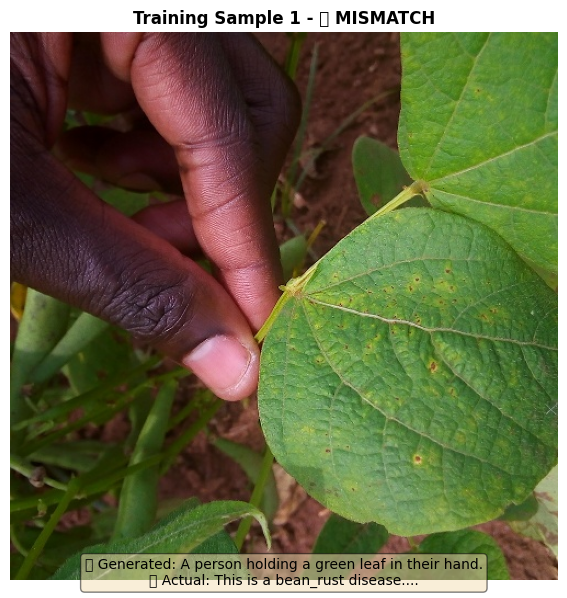


📸 Image 2:
   🤖 Generated: A person holding a green leaf in their hand.
   📝 Training target: This is a healthy leaf.
   ❌ MISMATCH


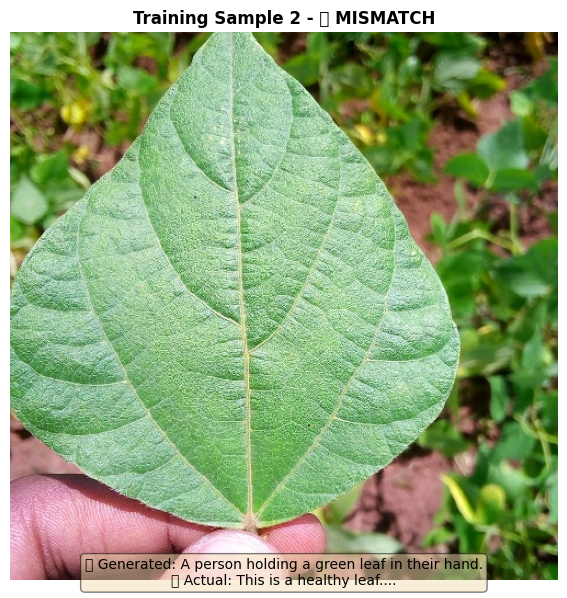


📸 Image 3:
   🤖 Generated: A person holding a leaf in a field of green plants.
   📝 Training target: This is a angular_leaf_spot disease.
   ❌ MISMATCH


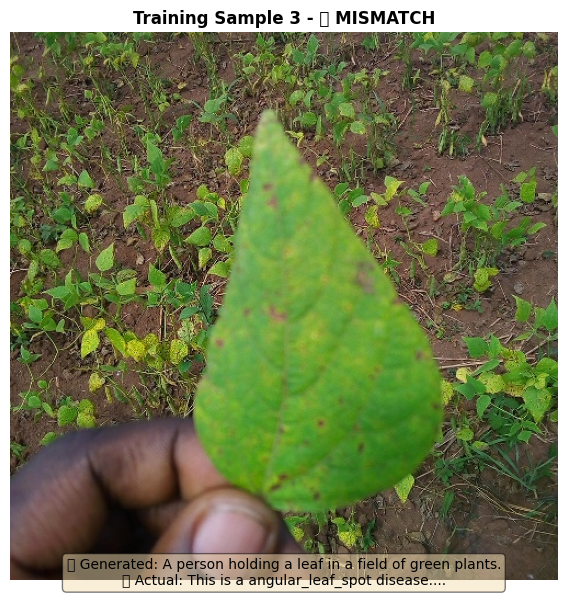


💡 KEY INSIGHT:

If the model memorized the training data, you should see:
- Generated captions similar to actual captions
- Lower loss = better memorization

If captions are wrong/gibberish:
- Need more training epochs
- Need more training data  
- There may still be format issues



In [47]:
# Test inference with image display
import matplotlib.pyplot as plt

print("=" * 60)
print("TESTING INFERENCE")
print("=" * 60)

# ============================================================
# IMPORTANT: Match inference task to training task!
# ============================================================
# The football dataset uses captions (text descriptions)
# So we trained with <CAPTION> task, not <VQA>
# We must use the same task for inference
# ============================================================

def display_inference_result(image, generated_caption, actual_caption=None, title="Inference Result"):
    """Display image alongside generated caption."""
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image)
    ax.axis('off')

    # Build caption text
    caption_text = f"🤖 Generated: {generated_caption}"
    if actual_caption:
        caption_text += f"\n📝 Actual: {actual_caption[:80]}..."

    ax.set_title(title, fontsize=12, fontweight='bold')
    fig.text(0.5, 0.02, caption_text, ha='center', fontsize=10, wrap=True,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()
    plt.show()

# Helper function to get the actual training target from a sample
def get_training_target(sample, ds_name):
    """
    Reconstruct the caption that was used during training.
    This must match the preprocessing logic!
    """
    # Check for direct text columns first
    if "text" in sample and sample["text"]:
        return sample["text"]
    if "caption" in sample and sample["caption"]:
        return sample["caption"]

    # Handle classification datasets (like beans, fashion_mnist)
    if "labels" in sample or "label" in sample:
        label = sample.get("labels", sample.get("label"))
        if isinstance(label, int):
            if ds_name == "beans":
                labels = {0: "angular_leaf_spot disease", 1: "bean_rust disease", 2: "healthy leaf"}
                return f"This is a {labels.get(label, 'plant leaf')}."
            elif ds_name == "fashion_mnist":
                labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
                          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
                return f"This is a {labels.get(label, 'clothing item')}."
            else:
                return f"Category: {label}"
        return str(label)

    return "N/A (unknown format)"

# Test with actual training images (this is what we trained on!)
if USE_REAL_DATASET and train_dataset is not None:
    print("\n🎯 Testing on TRAINING images (model should have memorized these):")
    print("-" * 50)

    # Test on first 3 training samples
    num_test = min(3, len(train_dataset))
    for i in range(num_test):
        try:
            sample = train_dataset[i]
            image = sample["image"]
            if isinstance(image, Image.Image):
                image = image.convert("RGB")

            # Generate caption
            generated = run_inference(image, "", task="<CAPTION>")

            # Get the ACTUAL training target (what we trained the model to output)
            actual = get_training_target(sample, dataset_name)

            print(f"\n📸 Image {i+1}:")
            print(f"   🤖 Generated: {generated}")
            print(f"   📝 Training target: {actual}")

            # Check if they match (rough comparison)
            match_status = "✅ MATCH" if actual.lower() in generated.lower() or generated.lower() in actual.lower() else "❌ MISMATCH"
            print(f"   {match_status}")

            # Display the image with captions
            display_inference_result(
                image,
                generated,
                actual,
                title=f"Training Sample {i+1} - {match_status}"
            )
        except Exception as e:
            print(f"   ⚠️ Error: {e}")
else:
    # Fallback to synthetic image
    print("\n🎯 Testing with synthetic image:")
    test_image = Image.new("RGB", (224, 224), color=(100, 150, 200))
    try:
        response = run_inference(test_image, "", task="<CAPTION>")
        print(f"🤖 Generated caption: {response}")
        display_inference_result(test_image, response, title="Synthetic Test Image")
    except Exception as e:
        print(f"⚠️ Inference error: {e}")

print("\n" + "=" * 60)
print("💡 KEY INSIGHT:")
print("=" * 60)
print("""
If the model memorized the training data, you should see:
- Generated captions similar to actual captions
- Lower loss = better memorization

If captions are wrong/gibberish:
- Need more training epochs
- Need more training data
- There may still be format issues
""")

## 14. Save Model

In [ ]:
# Save the fine-tuned LoRA adapters
save_path = "./vlm_lora_adapter"

model.save_pretrained(save_path)
processor.save_pretrained(save_path)

print(f"✅ Model saved to {save_path}")

# Check saved files
import os
saved_files = os.listdir(save_path)
print(f"Saved files: {saved_files[:10]}...")